# Exploring Toy Products on Amazon

Amazon.com needs no introduction --- the ubiquitious shopping platform dominates the online sales market in the United States and in certain parts internationally, and is one of the most important companies in the world.

In this notebook we will explore this dataset, a detailed toy products offered and sold on Amazon. We will probe the basic dataset attributes and hopefully uncover some interesting effects from the data! This exploratory data analytics notebook is recommended for beginners and those interested in probing this dataset further. Feel free to fork this notebook and/or copy the code here and explore further on your own!

![](http://ampthemag.com/wp-content/uploads/2017/08/AMAZON-1200x537.png)

In [2]:
import numpy as np
import pandas as pd

products = pd.read_csv("../data/amazon_co-ecommerce_sample.csv")

In [3]:
products.head(3)

,uniq_id,product_name,manufacturer,price,number_available_in_stock,number_of_reviews,number_of_answered_questions,average_review_rating,amazon_category_and_sub_category,customers_who_bought_this_item_also_bought,description,product_information,product_description,items_customers_buy_after_viewing_this_item,customer_questions_and_answers,customer_reviews,sellers
0,eac7efa5dbd3d667f26eb3d3ab504464,Hornby 2014 Catalogue,Hornby,£3.42,5 new,15,1.0,4.9 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,http://www.amazon.co.uk/Hornby-R8150-Catalogue...,Product Description Hornby 2014 Catalogue Box ...,Technical Details Item Weight640 g Product Dim...,Product Description Hornby 2014 Catalogue Box ...,http://www.amazon.co.uk/Hornby-R8150-Catalogue...,Does this catalogue detail all the previous Ho...,Worth Buying For The Pictures Alone (As Ever) ...,"{""seller""=>[{""Seller_name_1""=>""Amazon.co.uk"", ..."
1,b17540ef7e86e461d37f3ae58b7b72ac,FunkyBuys® Large Christmas Holiday Express Fes...,FunkyBuys,£16.99,NaN,2,1.0,4.5 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,http://www.amazon.co.uk/Christmas-Holiday-Expr...,Size Name:Large FunkyBuys® Large Christmas Hol...,Technical Details Manufacturer recommended age...,Size Name:Large FunkyBuys® Large Christmas Hol...,http://www.amazon.co.uk/Christmas-Holiday-Expr...,can you turn off sounds // hi no you cant turn...,Four Stars // 4.0 // 18 Dec. 2015 // By\n \...,"{""seller""=>{""Seller_name_1""=>""UHD WHOLESALE"", ..."
2,348f344247b0c1a935b1223072ef9d8a,CLASSIC TOY TRAIN SET TRACK CARRIAGES LIGHT EN...,ccf,£9.99,2 new,17,2.0,3.9 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,http://www.amazon.co.uk/Classic-Train-Lights-B...,BIG CLASSIC TOY TRAIN SET TRACK CARRIAGE LIGHT...,Technical Details Manufacturer recommended age...,BIG CLASSIC TOY TRAIN SET TRACK CARRIAGE LIGHT...,http://www.amazon.co.uk/Train-With-Tracks-Batt...,What is the gauge of the track // Hi Paul.Trut...,**Highly Recommended!** // 5.0 // 26 May 2015 ...,"{""seller""=>[{""Seller_name_1""=>""DEAL-BOX"", ""Sel..."


## Understanding how categories work

This dataset includes several columns which compress a lot of data into one field. First of all, let's take a look at the `amazon_category_and_sub_category` field.

This field is the ontological class given to the item in the record within Amazon's database. Amazon separates products out into a diverse range of categories, each subsetted and supersetted by other categories. The design of this ontology is controlled by both buyer concerns (categories need to be obviously useful to a consumer browsing the site and looking for products of a specific kind) and seller concerns (Amazon [controls](https://services.amazon.com/services/soa-approval-category.html) how listing a product on the site works category-by-category).

For this reason Amazon splits its categorization up into a tree structure. For example, one valid Amazon product classification is `Sports Toys & Outdoor > Beach Toys > Airbeds & Inflating Devices`. We need to take a look at how this categorization works to understand how to make use of it.

In [4]:
import numpy as np

def mapcategories(srs):
    if pd.isnull(srs):
        return []
    else:
        return [cat.strip() for cat in srs.split(">")]
    
category_lists = products['amazon_category_and_sub_category'].apply(mapcategories)
category_lists.map(lambda lst: len(lst)).value_counts()

amazon_category_and_sub_category
3    3990
2    3923
4    1312
0     690
5      85
Name: count, dtype: int64

For starters, an item can have a categorical tree with any number of nodes on it. Items with a two-element category and a three-element category are the two most common kinds. The ontology extends as far as five categories; and items can be listed without any category at all as well.

In [5]:
import networkx as nx
DG = nx.DiGraph()

category_lists.map(lambda cats: DG.add_nodes_from(cats))
category_lists.map(lambda cats: [DG.add_edge(cats[i], cats[i + 1]) for i in range(len(cats) - 1)])

print("The number of categorical links possible is {0}.".format(len(DG.edges())))

The number of categorical links possible is 324.


I expected the categories to form a tree: every category should have just one possible parent. Surprisingly, this does not hold, because in a couple of cases the sub-categories are duplicitious (as demonstrated below). E.g. `Sports Toys & Outdoor > Beach Toys > Beach Toys` is legit.

Since every product with a classification present has at least two categories in its categorical tree, let's just take the top-level (root) and bottom-level (leaf) categories as new categorical variables, and ignore the stuff in between.

In [6]:
# print(list(nx.simple_cycles(DG)))
# products.iloc[
#     category_lists[category_lists.map(lambda lst: 'Beach Toys' in lst)].index
# ].head()[['product_name', 'amazon_category_and_sub_category']]

top = category_lists[category_lists.map(lambda c: len(c) > 0)].map(lambda l: l[0])
bottom = category_lists[category_lists.map(lambda c: len(c) > 0)].map(lambda l: l[-1])

print("There are {0} possible top-level (root) categories in this dataset.".format(len(set(top))))
print("There are {0} possible bottom-level (leaf) categories in this dataset.".format(len(set(bottom))))

products = products.assign(root_category=top.astype('category'), 
                           leaf_category=bottom.astype('category'))

There are 43 possible top-level (root) categories in this dataset.
There are 235 possible bottom-level (leaf) categories in this dataset.


## Popular and valuable product categories

What are the most popular and/or valuable leaf-level product categories?

In [7]:
# Reformatting the number_of_reviews and price columns.
products['number_of_reviews'] = products['number_of_reviews'].str.replace(",", "").astype(float)

def mapprice(v):
    if pd.isnull(v):
        return 0
    try:
        return float(v[1:])
    except ValueError:
        return 0
    
products['price'] = products['price'].map(mapprice)

C:\Users\BMidd\AppData\Local\Temp\ipykernel_3644\1535693521.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  (products.groupby('leaf_category')
C:\Users\BMidd\AppData\Local\Temp\ipykernel_3644\1535693521.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  (products.groupby('leaf_category')
C:\Users\BMidd\AppData\Local\Temp\ipykernel_3644\1535693521.py:40: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('leaf_

TypeError: category type does not support sum operations

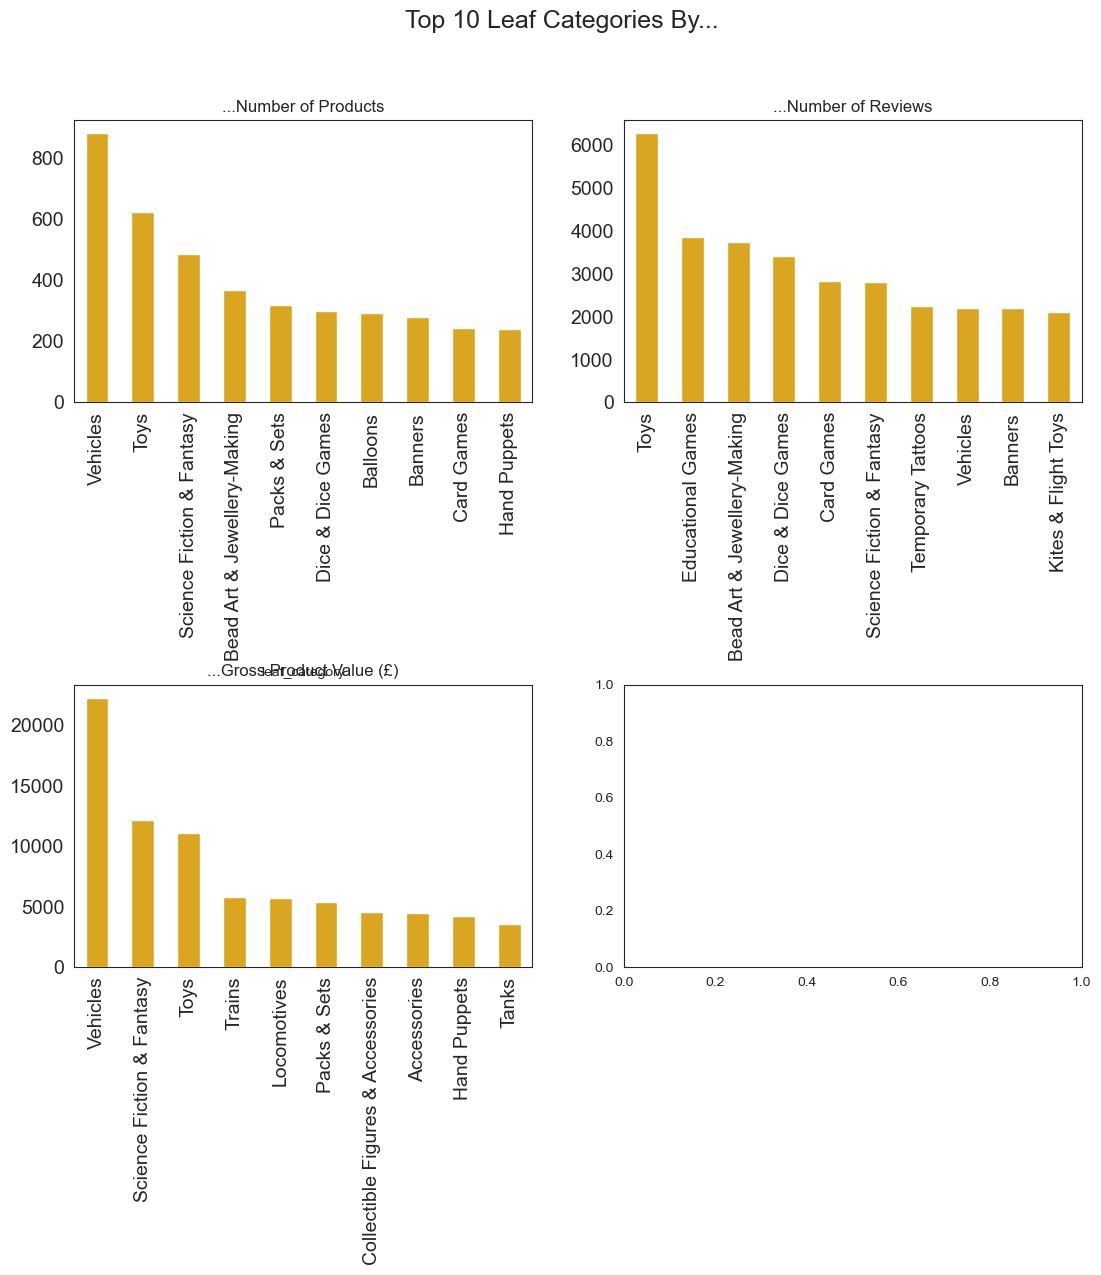

In [8]:
# Creating the plot.
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")

f, axarr = plt.subplots(2, 2)
f.subplots_adjust(hspace=1)
plt.suptitle('Top 10 Leaf Categories By...', fontsize=18)

bar_kwargs = {'figsize': (13, 11), 'fontsize': 14, 'color': 'goldenrod'}

products['leaf_category'].value_counts().head(10).plot.bar(
    title='...Number of Products', ax=axarr[0][0], **bar_kwargs
)

(products.groupby('leaf_category')
     ['number_of_reviews']
     .sum()
     .sort_values(ascending=False)
     .rename_axis(None)
     .head(10)
     .plot.bar(
        title='...Number of Reviews', ax=axarr[0][1], **bar_kwargs
     ))

(products.groupby('leaf_category')
     ['price']
     .sum()
     .sort_values(ascending=False)
     .rename_axis(None)
     .head(10)
     .plot.bar(
        title='...Gross Product Value (£)', ax=axarr[1][0], **bar_kwargs
     ))

(products
     .assign(
         pval=products.apply(lambda p: p['price'] * p['number_of_reviews'], axis='columns')
     )
     .groupby('leaf_category')
     .sum()
     .pipe(lambda df: df.assign(pval=df['pval'] / df['pval'].max()))
     .pval
     .sort_values(ascending=False)
     .rename_axis(None)
     .head(10)
     .plot.bar(
         title='...Product Value Sold (Index, Estimated)', 
         ax=axarr[1][1], **bar_kwargs
     )
)

sns.despine()

for (a, b) in [(0, 0), (0, 1), (1, 0), (1, 1)]:
    axarr[a][b].title.set_fontsize(16)
    axarr[a][b].set_xticklabels(axarr[a][b].get_xticklabels(), 
                                rotation=45, ha='right', fontsize=14)

When it comes to Amazon toy products, "Vehicles" are the most numerous and by far the most valuable in terms of gross product value. However the runner-up category of "Toys" has the most heavily reviewed items and also by far the highest product value sold.

To explore further, let's look at a by-category word cloud.

In [9]:
from wordcloud import WordCloud

def wordcloudify(cat):
    return WordCloud().generate(
        " ".join(products.query('leaf_category == "{0}"'.format(cat))['product_name'].values)
    )

f, axarr = plt.subplots(4, 1, figsize=(14, 32))
# f.subplots_adjust(hspace=1)

# Display the generated image:
axarr[0].imshow(wordcloudify("Toys"), 
                interpolation='nearest', aspect='auto')
axarr[0].axis("off")
axarr[0].set_title("Characters & Brands > ... > Toys", fontsize=16)

axarr[1].imshow(wordcloudify("Vehicles"), 
                interpolation='nearest', aspect='auto')
axarr[1].axis("off")
axarr[1].set_title("Die Cast & Toy Vehicles > ... > Vehicles", fontsize=16)

axarr[2].imshow(wordcloudify("Educational Games"), 
                interpolation='nearest', aspect='auto')
axarr[2].axis("off")
axarr[2].set_title("Games > ... > Education Games", fontsize=16)

axarr[3].imshow(wordcloudify("Science Fiction & Fantasy"), 
                interpolation='nearest', aspect='auto')
axarr[3].axis("off")
axarr[3].set_title("Figures & Playsets > ... > Science Fiction & Fantasy", fontsize=16)
pass

ModuleNotFoundError: No module named 'wordcloud'

**Brands are powerful**. Many of the most dominant words in the names of the toy products belong to brands, especially Disney, *especially* Star Wars.

The lumping of categories on Amazon is odd from an end-user perspective. Why do Teenage Mutant Ninja Turtle action figures, prominent in the Science Fiction & Fantasy category, *not* get lumped into Toys as well? I believe that a difference is drawn between large entertainment brands that license off toy production to consumer toy manufacturers *and* have a relationship with Amazon on the one hand (mainly Disney), and smaller studios or brand lines owned directly by manufacturers on the other. Still, it's kind of weird.

We see here that Vehicles seems to include die-cast cars and scale models that are drivable by children. The latter probably drives the high product value of this category---scale-model cars are an extremely expensive product, one kid-drivable Ferrari might cost as much as 500 action figures!

I looked at Educational Games because they have a high number of reviews. Clearly parents are highly involved in rating educational products on Amazon.

## Price breakdown by category

We'll take the ten most popular leaf categories and take a look at their price distribution. Note that items costing more than 100 pounds have been filtered out of this result to make the view more legible.

In [10]:
df = (products[
        products['leaf_category'].isin(
            list(products['leaf_category'].value_counts().head(10).index.values)
        )
      ].query('price > 0')
       .pipe(lambda df: df.assign(leaf_category=df['leaf_category'].astype(str)))
       .query('price < 100') 
       .sample(1000)
     )

with sns.plotting_context("notebook", font_scale=1.5):
    g = sns.FacetGrid(df, row='leaf_category', size=2.5, aspect=4)

    g.map(sns.violinplot, "price", inner=None, color='lightyellow', linewidth=1)
    g.map(sns.swarmplot, "price", size=8, color='goldenrod')
    g.despine(bottom=True, left=True)

TypeError: FacetGrid.__init__() got an unexpected keyword argument 'size'

## Manufacturers by price

I've always wondered how much a LEGO set costs.

In [11]:
products['manufacturer'].value_counts().head().index

Index(['LEGO', 'Disney', 'Oxford Diecast', 'Playmobil', 'Star Wars'], dtype='object', name='manufacturer')

In [ ]:
df = (products[
        products['manufacturer'].isin(
            ['Disney', 'Playmobil', 'LEGO', 'Hot Wheels', 'Mattel']
        )
      ]
         .query('price <= 100').query('price > 0'))

with sns.plotting_context("notebook", font_scale=1.5):
    g = sns.FacetGrid(df, row='manufacturer', hue='manufacturer', size=3, aspect=3.8)
    g.map(sns.kdeplot, "price", color='goldenrod', clip_on=False, shade=True)
    g.despine(bottom=True, left=True)
    g.set(yticks=[])

## Recommend me a new toy

Just for fun, let's build a trivial recommendation engine. We'll pick up the most heavily rated item which is rated over 4 stars, except for when no item matching our description with that high a rating is available, in which case we just return the highest-rated matching item.

In [ ]:
def splitrating(rating):
    try:
        return rating.split(" ")[0]
    except AttributeError:
        return np.nan

products['average_review_rating'] = products['average_review_rating'].map(splitrating)
products['average_review_rating'] = products['average_review_rating'].astype(float)

def recommend_me(item):
    tokens = item.split(" ")
    tokens = [t.lower() for t in tokens]
    df = products[products.product_name.map(lambda name: all(n in name.lower() for n in tokens))]
    
    if len(df[df['average_review_rating'] >= 4.0]) == 0:
        return df.sort_values(by='average_review_rating').iloc[0]
    else:
        return df[df['average_review_rating'] >= 4.0].sort_values(by='number_of_reviews').iloc[0]

In [ ]:
recommend_me("Star Wars Action Figure").product_name

<img src="https://images-na.ssl-images-amazon.com/images/I/31sgNb1LMYL.jpg" width="300">

In [ ]:
recommend_me("Fire Truck").product_name

<img src="https://images-na.ssl-images-amazon.com/images/I/71-gA2ObKzL._SL1441_.jpg" width="300">

In [ ]:
recommend_me("Pony").product_name

<img src="https://images-na.ssl-images-amazon.com/images/I/61w1RtkyVaL._SL1000_.jpg" width="300">

## Further ideas

That's all here folks! There are a lot of follow-up directions that you can use this dataset and notebook to explore. For example, here are some more things you can try with this dataset:

* Can you build a more rigorous recommendation engine? How similar are the results you get to the ones that Amazon (a leader in this arena) serves ( through the `customers_who_bought_this_item_also_bought` field)?
* What is the difference between the `customers_who_bought_this_item_also_bought` and `items_customers_buy_after_viewing_this_item` fields? How does Amazon tie these two concepts (one a prediction, and one an actual outcome) together?
* What other things can you learn about manufacturers by examining the products that they sell? How about the sellers?